In [1]:
#import geopandas
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os, os.path
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from ipynb.fs.full.interp_data import interpolate_scenario_data

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set_style("ticks")

In [4]:
C1_c = "#649B1C"
C2_c = "#00B593"
C3_c = "#4E84D4"

### AR6 dataset
- Showing the gap between committed capacity and AR6
- Using secondary energy instead of primary - because emission factors need to multiply with primary, but actual electricity generation is secondary

In [5]:
# load data
ar6_world = pd.read_csv("../../data/AR6_data/1668008174375-AR6_Scenarios_Database_R10_regions_v1.1.csv/AR6_Scenarios_Database_R10_regions_v1.1.csv")
ar6_scen = pd.read_excel("../../data/AR6_data/AR6_Scenarios_Database_World_v1.1/AR6_Scenarios_Database_metadata_indicators_v1.1.xlsx",sheet_name = "meta_Ch3vetted_withclimate")

In [6]:
crosswalk = pd.read_excel("../../data/MESSAGE/mapping_file_R10edit.xlsx",sheet_name="main")
AR6_list = crosswalk["AR6_R10"].unique()
crosswalk.head()

,Countries,R10,AR6_R10,GEM_Name,ISO
0,Algeria,Africa (R10),R10AFRICA,Algeria,DZA
1,Angola,Africa (R10),R10AFRICA,Angola,AGO
2,Benin,Africa (R10),R10AFRICA,NaN,BEN
3,Botswana,Africa (R10),R10AFRICA,NaN,BWA
4,Burkina Faso,Africa (R10),R10AFRICA,NaN,BFA


In [7]:
ar6_scen_123 = ar6_scen[ar6_scen["Category"].isin(["C1","C2","C3"])]

In [8]:
def melt_data(ar6_world, ar6_scen_123, variable, script):
    """
    variable = 'Primary Energy|Gas|Electricity|w/o CCS'
    """
    ar6_data = ar6_world.query("Variable==@variable") #Capacity|Electricity|Coal|w/o CCS
    ar6_data = interpolate_scenario_data(ar6_data)
    ar6_data = pd.merge(ar6_data,ar6_scen_123[["Model","Scenario","Category"]],
                                      left_on=["Model","Scenario"],right_on=["Model","Scenario"])
    ar6_data_melt = pd.melt(ar6_data,id_vars=["Model","Scenario","Category","Region"],value_vars=ar6_data.columns[5:-1],
                                 var_name="Year",value_name=ar6_data["Unit"].iloc[0]+"_"+script).dropna()
    ar6_data_melt["Year"] = ar6_data_melt["Year"].astype(int)
    ar6_data_melt = ar6_data_melt.sort_values("Category")
    
    return ar6_data_melt

In [9]:
ar6_world_gas_melt = melt_data(ar6_world, ar6_scen_123, "Secondary Energy|Electricity|Gas|w/o CCS","Gas")

In [10]:
ar6_world_coal_melt = melt_data(ar6_world, ar6_scen_123, "Secondary Energy|Electricity|Coal|w/o CCS","Coal")

In [11]:
ar6_world_gas_melt.set_index("Model").to_csv("AR6_Gas_GW_R10.csv")
ar6_world_coal_melt.set_index("Model").to_csv("AR6_Coal_GW_R10.csv")

In [13]:
ar6_solarcap_melt = melt_data(ar6_world, ar6_scen_123, "Capacity|Electricity|Solar","Solar")
ar6_windcap_melt = melt_data(ar6_world, ar6_scen_123, "Capacity|Electricity|Wind","Wind")

In [35]:
ar6_world_gas_melt[ar6_world_gas_melt["Year"]==2023]

,Model,Scenario,Category,Region,Year,EJ/yr_Gas
62153,WITCH 5.0,EN_NPi2020_500f,C1,R10REF_ECON,2023,3.287290
62154,WITCH 5.0,EN_NPi2020_500f,C1,R10REST_ASIA,2023,1.713943
62152,WITCH 5.0,EN_NPi2020_500f,C1,R10PAC_OECD,2023,1.251238
62151,WITCH 5.0,EN_NPi2020_500f,C1,R10NORTH_AM,2023,4.293194
62150,WITCH 5.0,EN_NPi2020_500f,C1,R10MIDDLE_EAST,2023,4.475911
...,...,...,...,...,...,...
58344,COFFEE 1.1,EN_INDCi2030_900,C3,R10REF_ECON,2023,1.856570
58343,COFFEE 1.1,EN_INDCi2030_900,C3,R10PAC_OECD,2023,1.329444
58342,COFFEE 1.1,EN_INDCi2030_900,C3,R10NORTH_AM,2023,6.364059
58341,COFFEE 1.1,EN_INDCi2030_900,C3,R10MIDDLE_EAST,2023,3.123918


In [18]:
ar6_re_melt = pd.merge(ar6_solarcap_melt,ar6_windcap_melt,on=["Model","Scenario","Category","Region","Year"])
ar6_re_melt["GW_RE"] = ar6_re_melt["GW_Solar"] + ar6_re_melt["GW_Wind"] 
ar6_re_melt["TW_RE"] = ar6_re_melt["GW_RE"]/1000
ar6_re_melt

,Model,Scenario,Category,Region,Year,GW_Solar,GW_Wind,GW_RE,TW_RE
0,WITCH 5.0,EN_NPi2020_500,C1,R10AFRICA,2043,162.421674,67.472504,229.894178,0.229894
1,GEM-E3_V2021,EN_NPi2020_600_COV,C1,R10ROWO,2061,1966.719155,1219.393868,3186.113024,3.186113
2,AIM/CGE 2.2,EN_NPi2020_300f,C1,R10REST_ASIA,2055,939.495200,913.468400,1852.963600,1.852964
3,AIM/CGE 2.2,EN_NPi2020_300f,C1,R10REF_ECON,2055,1191.981600,478.518300,1670.499900,1.670500
4,AIM/CGE 2.2,EN_NPi2020_300f,C1,R10PAC_OECD,2055,384.896900,135.691000,520.587900,0.520588
...,...,...,...,...,...,...,...,...,...
346469,AIM/CGE 2.2,EN_NPi2020_1000,C3,R10AFRICA,2070,869.924800,608.723500,1478.648300,1.478648
346470,AIM/CGE 2.2,EN_INDCi2030_900f,C3,R10REST_ASIA,2070,1349.736400,1321.832100,2671.568500,2.671569
346471,AIM/CGE 2.2,EN_INDCi2030_900f,C3,R10REF_ECON,2070,1403.725300,573.795800,1977.521100,1.977521
346472,AIM/CGE 2.2,EN_NPi2020_1000,C3,R10REF_ECON,2070,1273.360600,509.129400,1782.490000,1.782490


### historical data

https://www.google.com/search?q=coal+heat+rate&rlz=1C1GCEA_enGB932GB932&oq=coal+heat+rate&gs_lcrp=EgZjaHJvbWUqCQgAECMYJxiKBTIJCAAQIxgnGIoFMggIARAAGBYYHjIICAIQABgWGB4yCggDEAAYDxgWGB4yCggEEAAYhgMYigUyCggFEAAYhgMYigXSAQgyMzA5ajBqNKgCALACAA&sourceid=chrome&ie=UTF-8

In [80]:
# GAS
## [EJ/yr] = [MWh/yr] * [3.6x10-9 EJ/MWh]
historical_gas = pd.read_csv("gas_historical.csv")
historical_gas["EJ/yr"] = historical_gas["MWh/yr"] * 3.6 / (10**9) 
aged_gas = pd.read_csv("gas_aged.csv")
future_gas = pd.read_csv("gas_future.csv")
commited_gas = pd.concat([historical_gas[historical_gas["Year"]==2023],aged_gas,future_gas])
commited_gas["EJ/yr"] = commited_gas["MWh/yr"] * 3.6 / (10**9) 
const_gas = pd.read_csv("gas_construction.csv")
const_gas["EJ/yr"] = const_gas["MWh/yr"] * 3.6 / (10**9) 
commited_gas

,Year,AR6_R10,GW,Type,MWh/yr,MtCO2/yr,EJ/yr,aged,GW_new
709,2023,R10AFRICA,112.377,Historical,344547882.0,227.057054,1.240372,NaN,NaN
710,2023,R10CHINA+,121.725,Historical,373208850.0,245.944632,1.343552,NaN,NaN
711,2023,R10EUROPE,226.949,Historical,695825634.0,458.549093,2.504972,NaN,NaN
712,2023,R10INDIA+,56.050,Historical,171849300.0,113.248689,0.618657,NaN,NaN
713,2023,R10LATIN_AM,116.036,Historical,355766376.0,234.450042,1.280759,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1375,2073,R10MIDDLE_EAST,0.000,Current_high,0.0,0.000000,0.000000,0.0,NaN
1376,2073,R10NORTH_AM,0.000,Current_high,0.0,0.000000,0.000000,0.0,NaN
1377,2073,R10PAC_OECD,0.000,Current_high,0.0,0.000000,0.000000,0.0,NaN
1378,2073,R10REF_ECON,0.000,Current_high,0.0,0.000000,0.000000,0.0,NaN


In [98]:
# COAL
historical_coal = pd.read_csv("coal_historical.csv")
historical_coal["EJ/yr"] = historical_coal["MWh/yr"] * 3.6 / (10**9) 
historical_coal["Type"] = "placeholder"
committed_coal = pd.read_csv("coal_commited.csv")
committed_coal["EJ/yr"] = committed_coal["MWh/yr"] * 3.6 / (10**9) 
committed_coal["Type"] = "placeholder"
const_coal = pd.read_csv("coal_construction.csv")
const_coal["EJ/yr"] = const_coal["MWh/yr"] * 3.6 / (10**9) 
const_coal

,Unnamed: 0,Year,AR6_R10,Type,MW,AnnualMtCO2,MWh/yr,GW,EJ/yr
0,0,2023,R10AFRICA,Construction_low,51386.10,255.2,2.385754e+08,51.38610,0.858871
1,1,2023,R10CHINA+,Construction_low,1125082.00,5089.5,5.223531e+09,1125.08200,18.804711
2,2,2023,R10EUROPE,Construction_low,135633.86,706.1,6.297209e+08,135.63386,2.266995
3,3,2023,R10INDIA+,Construction_low,246956.70,1144.3,1.146571e+09,246.95670,4.127654
4,4,2023,R10LATIN_AM,Construction_low,16494.00,84.3,7.657834e+07,16.49400,0.275682
...,...,...,...,...,...,...,...,...,...
1555,6,2074,R10EUROPE,Construction_mid,0.00,0.0,0.000000e+00,0.00000,0.000000
1556,7,2074,R10LATIN_AM,Construction_mid,0.00,0.0,0.000000e+00,0.00000,0.000000
1557,8,2074,R10REF_ECON,Construction_mid,0.00,0.0,0.000000e+00,0.00000,0.000000
1558,9,2074,R10PAC_OECD,Construction_mid,0.00,0.0,0.000000e+00,0.00000,0.000000


### plot

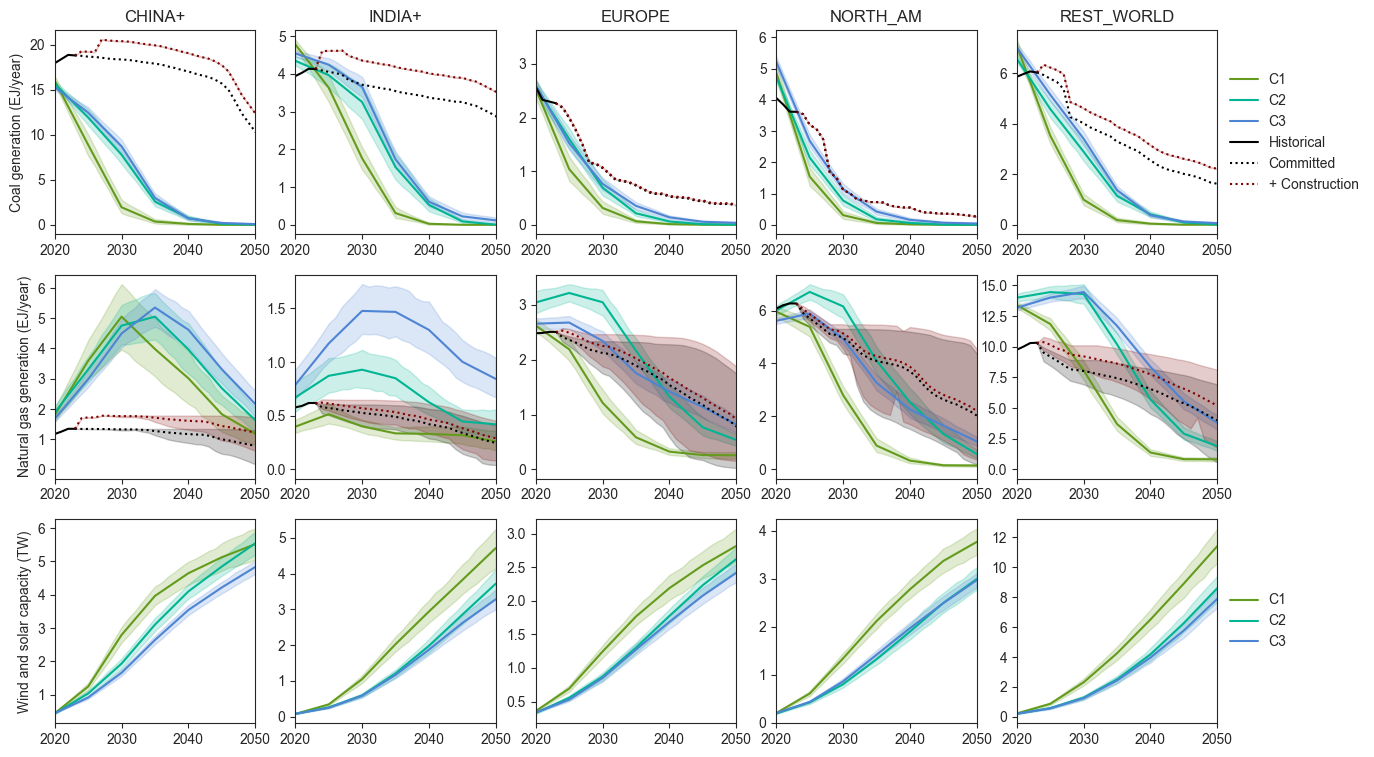

In [102]:
fig, axes = plt.subplots(3,5,figsize=(15,9))
region_select = ['R10CHINA+', 'R10INDIA+','R10EUROPE','R10NORTH_AM']
region_remain = ['R10AFRICA', 'R10LATIN_AM', 'R10MIDDLE_EAST','R10PAC_OECD', 'R10REF_ECON','R10REST_ASIA',"R10ROWO"]

plot_type = "2050"

for tech in ["Coal","Gas","Renewable"]:
    if tech == "Coal":
        melted_data = ar6_world_coal_melt
        melted_data_col = "EJ/yr_Coal"
        row_num = 0
        caption = "Coal generation (EJ/year)"
        historical_data = historical_coal
        commited_data = committed_coal
        const_data = const_coal
    elif tech == "Gas":
        melted_data = ar6_world_gas_melt
        melted_data_col = "EJ/yr_Gas"
        row_num = 1
        caption = "Natural gas generation (EJ/year)"
        historical_data = historical_gas
        commited_data = commited_gas
        const_data = const_gas
    elif tech == "Renewable":
        melted_data = ar6_re_melt
        melted_data_col = "TW_RE"
        row_num = 2
        caption = "Wind and solar capacity (TW)"
    
    if plot_type == "2050":
        melted_data = melted_data[melted_data["Year"]<=2050]
        melted_data = melted_data[melted_data["Year"]>=2020]
    
    for n_r10 in np.arange(len(region_select)+1):
        this_ax = axes[row_num,n_r10]
        if n_r10 < 4: # separate R10 regions
            r10 = region_select[n_r10]
            melted_data_r = melted_data[melted_data["Region"]==r10]
            if tech != "Renewable":
                historical_data_r = historical_data[historical_data["AR6_R10"]==r10]
                commited_data_r = commited_data[commited_data["AR6_R10"]==r10]
                const_data_r = const_data[const_data["AR6_R10"]==r10]
        else: # summarize data in the wolrd
            r10 = "R10REST_WORLD"
            melted_data_remain = melted_data[melted_data["Region"].isin(region_remain)]
            melted_data_r = melted_data_remain.groupby(["Year","Model","Scenario","Category"]).sum()[[melted_data_col]]
            melted_data_r = melted_data_r.sort_values("Category")
            if tech != "Renewable":
                historical_data_remain = historical_data[historical_data["AR6_R10"].isin(region_remain)]
                historical_data_r = historical_data_remain.groupby(["Year","Type"]).sum()[["EJ/yr"]]
                committed_data_remain = commited_data[commited_data["AR6_R10"].isin(region_remain)]
                commited_data_r = committed_data_remain.groupby(["Year","Type"]).sum()[["EJ/yr"]]
                const_data_remain = const_data[const_data["AR6_R10"].isin(region_remain)]
                const_data_r = const_data_remain.groupby(["Year","Type"]).sum()[["EJ/yr"]]
            
        sns.lineplot(x='Year', y=melted_data_col, hue='Category', data=melted_data_r,palette=[C1_c,C2_c,C3_c],ax=this_ax)
        if tech != "Renewable":
            sns.lineplot(x='Year', y='EJ/yr', data=historical_data_r,ax=this_ax,color="black",label="Historical")
            sns.lineplot(x='Year', y='EJ/yr', data=commited_data_r,ax=this_ax,color="black",label="Committed",linestyle=":")
            sns.lineplot(x='Year', y='EJ/yr', data=const_data_r,ax=this_ax,color="maroon",label="+ Construction",linestyle=":")
        
        this_ax.set_xlabel(None)
        if row_num == 0:
            this_ax.set_title(r10[3:])
            
        if n_r10 == 4 and (row_num==0 or row_num==2):
            this_ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False)
        else:
            this_ax.get_legend().remove()

        if n_r10 == 0 :
            this_ax.set_ylabel(caption)
        else:
            this_ax.set_ylabel(None)

        if plot_type == "hist":
            this_ax.set_xlim([1980,2100])
        elif plot_type == "2050":
            this_ax.set_xlim([2020,2050])
            
fig.savefig("committed_gaps_"+plot_type+"_R10.png",dpi=600, bbox_inches='tight')